In [3]:
from datetime import time
from matplotlib import markers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from glob import glob
from seaborn import palettes
from seaborn.categorical import swarmplot
from tqdm import tqdm
import json
from scipy.signal import detrend
from scipy.ndimage import gaussian_filter1d
import os
import re
import math
import matplotlib.ticker as tck
import glob
import argparse

In [106]:
paths = glob.glob(os.path.join("D:/Turku/lunagel_50s/remodelling", "**","summary_ID_level.csv"),recursive=True)
print(paths)

['D:/Turku/lunagel_50s/remodelling\\24_120\\1\\241111\\241111_10um_3layer_50s_MDAMB231\\results\\summary_ID_level.csv', 'D:/Turku/lunagel_50s/remodelling\\24_120\\1\\241111\\241111_10um_3layer_50s_control\\results\\summary_ID_level.csv', 'D:/Turku/lunagel_50s/remodelling\\24_120\\0\\241107\\241107_10um_3layer_50s_control\\results\\summary_ID_level.csv', 'D:/Turku/lunagel_50s/remodelling\\24_120\\0\\241107\\241107_10um_3layer_50s_MDAMB231\\results\\summary_ID_level.csv', 'D:/Turku/lunagel_50s/remodelling\\48_144\\0\\241108\\241108_10um_3layer_50s_control\\results\\summary_ID_level.csv', 'D:/Turku/lunagel_50s/remodelling\\48_144\\0\\241108\\241108_10um_3layer_50s_MDAMB231\\results\\summary_ID_level.csv', 'D:/Turku/lunagel_50s/remodelling\\48_144\\1\\241112\\241112_10um_3layer_50s_control\\results\\summary_ID_level.csv', 'D:/Turku/lunagel_50s/remodelling\\48_144\\1\\241112\\241112_10um_3layer_50s_MDAMB231\\results\\summary_ID_level.csv']


In [116]:
df_list = []

for i in (paths):
    k=0
    data = pd.read_csv(i)
    parts = i.split('\\')
    data['set'] = parts[1]
    data['set_id'] = parts[2]
    data['date'] = parts[3] 
    data['sample'] = parts[4].split('_')[4]
    df_list.append(data)
    print(f"{parts[1]},{parts[2]},{ parts[3] },{parts[4].split('_')[4]}")
    

df = pd.concat(df_list, ignore_index=True)


24_120,1,241111,MDAMB231
24_120,1,241111,control
24_120,0,241107,control
24_120,0,241107,MDAMB231
48_144,0,241108,control
48_144,0,241108,MDAMB231
48_144,1,241112,control
48_144,1,241112,MDAMB231


In [ ]:
saving_path = 'C:/Users/srboval1/OneDrive - Aalto University/Collab/Ivaska_collab/data'
df.to_csv(saving_path+'/gradients.csv')  


In [5]:

download = pd.read_csv(saving_path +'/gradients.csv', index_col=None)
print(download.columns)


Index(['Unnamed: 0', 'day', 'sample', 'holder', 'location', 'track_id',
       'reference_id', 'distance(um)', 'Cov_Sum', 'a_(um)', 'phi_(rad)', 'c',
       'd', 'G_abs', 'radius_(m)', 'rmse', 'inv.rmse', 'shift_(s)', 'a_error',
       'phi_error', 'c_error', 'd_error', 'x', 'y', 'repeat', 'phi_(deg)',
       'tan_phi', 'set', 'set_id', 'date', 'gradient', 'x_con'],
      dtype='object')


In [28]:
alpha = 0.05
def GLS(data,ax, color):
    import statsmodels.api as sm

    x= data['f'].values.reshape(-1,1)
    y= np.log(data['G_abs'])

    # Fit GLS model
    x_const = sm.add_constant(x)  # adds a column of ones to independent variable - allows to estimate the intercept
    
    #Fitting the model to the data
    modelGLS = sm.GLS(y,x_const)

    #Model parameters
    resultsGSL = modelGLS.fit()
    print(resultsGSL.summary())

    #CI
    confidence_intervals = resultsGSL.conf_int(alpha=0.05)

    # Generate predictions for the original data
    x_predictedGLS = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)  # Model x-space
    x_predictedGLS_with_const = sm.add_constant(x_predictedGLS)  # Add constant for predictions

    # Prediction of y based on the model
    y_predictedGLS = resultsGSL.predict(x_predictedGLS_with_const)  # Get predictions

    # CI for the predictions
    predictions = resultsGSL.get_prediction(x_predictedGLS_with_const)
    pred_summary = predictions.summary_frame(alpha=alpha)  #

    ax.scatter(data['f'],data['G_abs'],s=4, c=color) #measured from soft to stiff
    #ax.plot(x_predictedGLS, y_predictedGLS, color=color, label='Fitted Line')  # Fitted line
    ax.fill_between(x_predictedGLS.flatten(), pred_summary['obs_ci_lower'], pred_summary['obs_ci_upper'],
                    color='orange', alpha=0.3, label='Confidence Interval')
    ax.set_ylim (0,100) 
    ax.set_xlim (0,5000)  

    #print(resultsGSL.bse)


1
                            GLS Regression Results                            
Dep. Variable:                  G_abs   R-squared:                       0.080
Model:                            GLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     5.753
Date:                Wed, 13 Nov 2024   Prob (F-statistic):             0.0193
Time:                        01:14:36   Log-Likelihood:                -90.393
No. Observations:                  68   AIC:                             184.8
Df Residuals:                      66   BIC:                             189.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2891      0.237     13.898      0

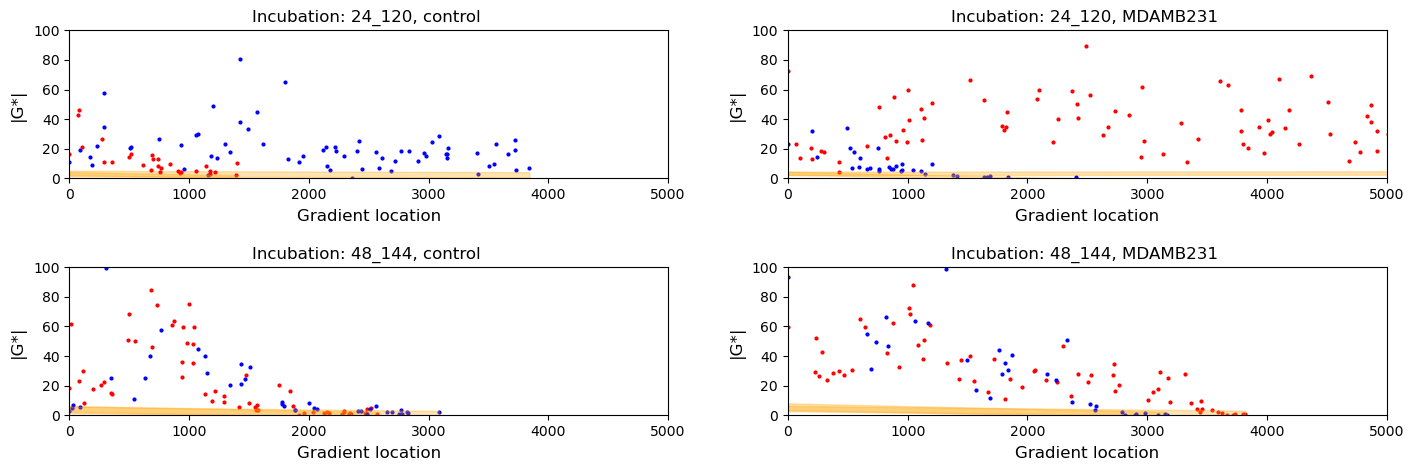

In [29]:
fig, axs = plt.subplots(2, (len(download['set'].unique())), figsize=(17, 5))
plt.subplots_adjust(wspace=0.2, hspace=0.6)
fig.suptitle("", fontsize=18, y=1)

colors = ["red","blue"]
for i,j in enumerate(download['set'].unique()):
    dff = download[download['set']==j]
    row = i
    for n in(dff['set_id'].unique()):
        print(n)
        dfff = dff[dff['set_id']==n]
        color = colors[int(n)]
        for m,n in enumerate(dfff['sample'].unique()):
            dffff = dfff[dfff['sample']==n]
            dffff = dffff.copy()
            if (n == "MDAMB231") & (dfff['date'].unique() == "241107"):
                dffff['f'] = dffff['gradient']
            else:
                dffff['f'] = dffff['gradient'].max() - dffff['gradient']
            col = m
            ax = axs[row,col]
            GLS(dffff, ax,color)
            ax.set_xlabel("Gradient location", fontsize= 12,labelpad=5)
            ax.set_ylabel("|G*|", fontsize= 12, labelpad=5)
            ax.set_title(f"Incubation: {j}, {n} ", fontsize = 12)
            ax.set_ylim (0,100) 
            ax.set_xlim (0,5000)  

1
1
1
1


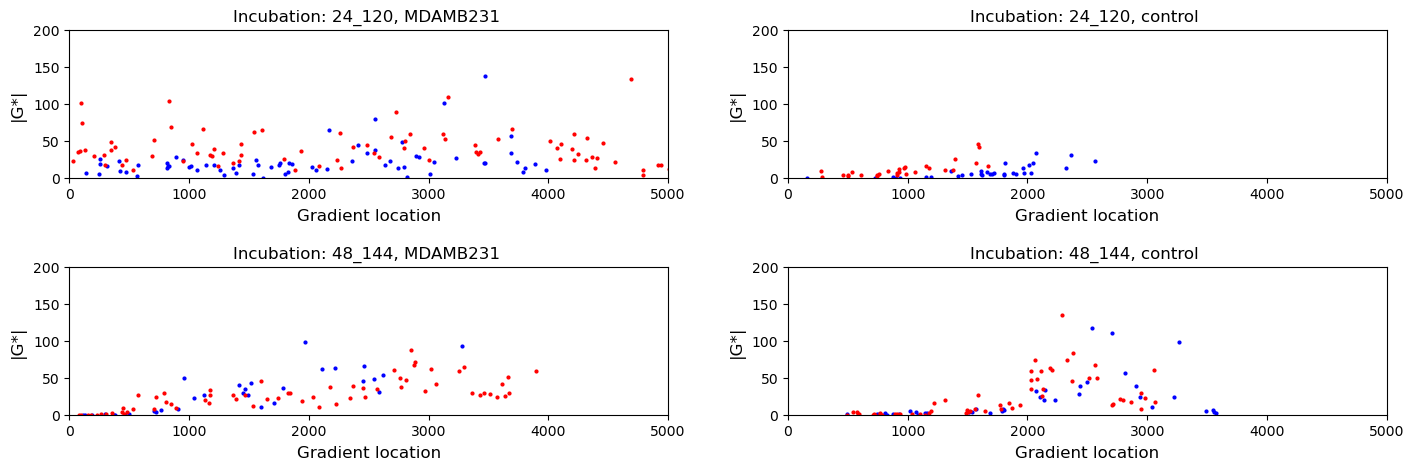

In [ ]:
fig, axs = plt.subplots(2, (len(df['set'].unique())), figsize=(17, 5))
plt.subplots_adjust(wspace=0.2, hspace=0.6)
fig.suptitle("", fontsize=18, y=1)

colors = ["red","blue"]
for i,j in enumerate(df['set'].unique()):
    dff = df[df['set']==j]
    row = i
    for n in(df['set_id'].unique()):
        dfff = dff[dff['set_id']==n]
        color = colors[int(n)]
        for m,n in enumerate(df['sample'].unique()):
            dffff = dfff[dfff['sample']==n]
            col = m
            ax = axs[row,col]
            ax.scatter(dffff['gradient'],dffff['G_abs'],s=4, c=color) #measured from soft to stiff
            ax.set_xlabel("Gradient location", fontsize= 12,labelpad=5)
            ax.set_ylabel("|G*|", fontsize= 12, labelpad=5)
            ax.set_title(f"Incubation: {j}, {n} ", fontsize = 12)
            ax.set_ylim (0,200) 
            ax.set_xlim (0,5000)  

Text(0.5, 1.0, 'Cell sample 24h')

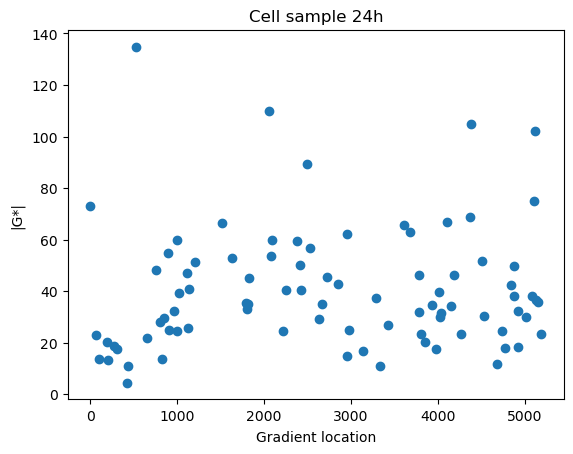

In [ ]:
plt.scatter(df['x_con'],df['G_abs'])
plt.xlabel("Gradient location", fontsize= 10,labelpad=5)
plt.ylabel("|G*|", fontsize= 10, labelpad=5)
plt.title('Cell sample 24h')


Text(0.5, 1.0, 'Control sample 24h')

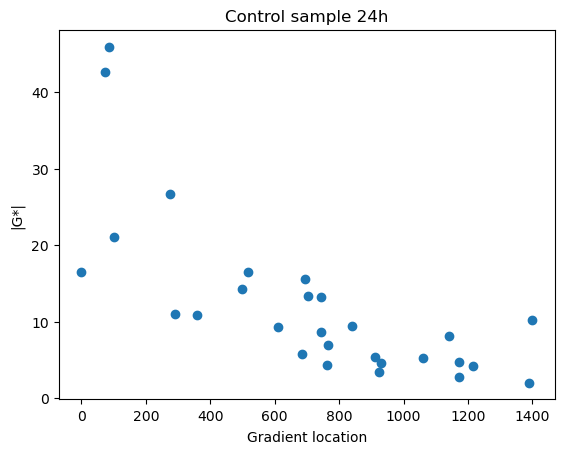

In [9]:
max = control['gradient'].max()
control['x_con'] = max -control['gradient']
control.to_csv('C:/Users/srboval1/OneDrive - Aalto University/Collab/Ivaska_collab/data/241107_24h_control', index=False)

plt.scatter(control['x_con'],control['G_abs'])
plt.xlabel("Gradient location", fontsize= 10,labelpad=5)
plt.ylabel("|G*|", fontsize= 10, labelpad=5)
plt.title('Control sample 24h')